### Multichannel CNN
Resource: https://arxiv.org/pdf/1408.5882.pdf

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Model
import pandas as pd
from utils import *
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import keras

Using TensorFlow backend.


### Get the data

In [2]:
#Get raw documents:
train, test, labels = getData()
labels = map(int, labels)

In [3]:
train, _X, labels, _Y = train_test_split(train, labels, test_size=0.20, random_state=42)

In [4]:
len(train),len(_X), len(_Y), len(labels)

(26010, 6503, 6503, 26010)

In [5]:
char_tokenizer = Char_tokenizer(train+test)
X_train = char_tokenizer.transform(train)
X_test = char_tokenizer.transform(test)

#and one hot encode y:
y_train = keras.utils.to_categorical(labels, 12)

### Define model

In [6]:
def getModel(maxlen, embedding_size=13, max_features=27):
    
    # Input layers, shared by all channels
    inputLayer = Input(shape=(maxlen,))
    e = Embedding(max_features, embedding_size)(inputLayer)

    #Create 3 channels of CNN layers (embedding->conv1D->Dropout->MaxPooling1D->Flatten)
    embeddingLayer = Dropout(0.40)(e)
    
#     flat0 = Flatten()(
#                 MaxPooling1D(pool_size=2)(
#                     Dropout(0.5)(
#                         Conv1D(filters=32, kernel_size=3, activation='relu')(
#                             embeddingLayer))))
    
    
    flat1 = Flatten()(
                MaxPooling1D(pool_size=2)(
                    Dropout(0.5)(
                        Conv1D(filters=32, kernel_size=4, activation='relu')(
                            embeddingLayer))))
    
    
#     flat4 = Flatten()(
#                 MaxPooling1D(pool_size=2)(
#                     Dropout(0.5)(
#                         Conv1D(filters=32, kernel_size=5, activation='relu')(
#                             embeddingLayer))))
    
    flat2 = Flatten()(
                MaxPooling1D(pool_size=2)(
                    Dropout(0.5)(
                        Conv1D(filters=32, kernel_size=6, activation='relu')(
                            embeddingLayer))))

    flat3 = Flatten()(
                MaxPooling1D(pool_size=2)(
                    Dropout(0.5)(
                        Conv1D(filters=32, kernel_size=8, activation='relu')(
                            embeddingLayer))))
    d = Dropout(0.50)(concatenate([flat1, flat2, flat3]))
    # Merge them and connect to FC layers
    #dense = Dense(100, activation='relu')(d)
    dense2 = Dense(100, activation='relu')(d)
    outputs = Dense(12, activation='sigmoid')(dense2)
    model = Model(inputs=inputLayer, outputs=outputs)
    return model

In [9]:
model = getModel(X_train.shape[1])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=512)

Train on 23409 samples, validate on 2601 samples
Epoch 1/10
23409/23409 [==============================] - 33s 1ms/step - loss: 2.3466 - acc: 0.1557 - val_loss: 2.3650 - val_acc: 0.1499
Epoch 2/10
23409/23409 [==============================] - 33s 1ms/step - loss: 2.3045 - acc: 0.1603 - val_loss: 2.3088 - val_acc: 0.1538
Epoch 3/10
23409/23409 [==============================] - 35s 1ms/step - loss: 2.2434 - acc: 0.2019 - val_loss: 2.2262 - val_acc: 0.2245
Epoch 4/10
23409/23409 [==============================] - 32s 1ms/step - loss: 2.1326 - acc: 0.2546 - val_loss: 2.1606 - val_acc: 0.2618
Epoch 5/10
23409/23409 [==============================] - 32s 1ms/step - loss: 2.0398 - acc: 0.2893 - val_loss: 2.0897 - val_acc: 0.2895
Epoch 6/10
23409/23409 [==============================] - 34s 1ms/step - loss: 1.9829 - acc: 0.3126 - val_loss: 2.0639 - val_acc: 0.2957
Epoch 7/10
23409/23409 [==============================] - 33s 1ms/step - loss: 1.9424 - acc: 0.3246 - val_loss: 2.0312 - val_acc:

['acc', 'loss', 'val_acc', 'val_loss']


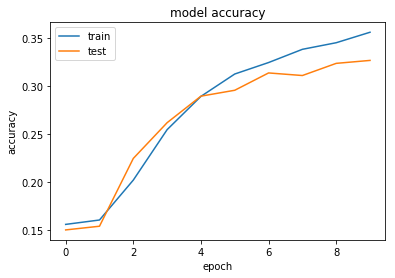

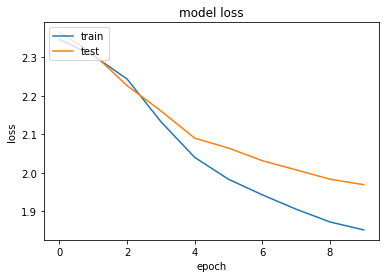

In [10]:
plotHistory(history)

## 2. Try with ngram (n=3) embeddings

In [7]:
n = 3
maxLen = getNgramMaxLen(n)
X_train_ngram, max_features = getX(train, n, maxLen)
__X, max_features = getX(_X, n, maxLen)
__Y = keras.utils.to_categorical(_Y, 12)

In [8]:
X_train_ngram.shape, y_train.shape, max_features

((26010, 1353), (26010, 12), 2912)

In [9]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [10]:
model = getModel(X_train_ngram.shape[1], 13, max_features)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
history = model.fit(X_train_ngram, y_train, validation_split=0.1, epochs=10, batch_size=512)

Train on 23409 samples, validate on 2601 samples
Epoch 1/10


InvalidArgumentError: indices[483,988] = 3097 is not in [0, 2912)
	 [[Node: embedding_1/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_1/embeddings/read, embedding_1/Cast)]]

Caused by op u'embedding_1/Gather', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 1065, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-5b3eb39df5c5>", line 1, in <module>
    model = getModel(X_train_ngram.shape[1], 13, max_features)
  File "<ipython-input-6-9d3cfed8f140>", line 5, in getModel
    e = Embedding(max_features, embedding_size)(inputLayer)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/embeddings.py", line 138, in call
    out = K.gather(self.embeddings, inputs)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 1208, in gather
    return tf.gather(reference, indices)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/array_ops.py", line 2585, in gather
    params, indices, validate_indices=validate_indices, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 1864, in gather
    validate_indices=validate_indices, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): indices[483,988] = 3097 is not in [0, 2912)
	 [[Node: embedding_1/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](embedding_1/embeddings/read, embedding_1/Cast)]]


In [34]:
#loss, acc = model.evaluate(__X, __Y, verbose=0)
loss, acc = model.evaluate(X_train_ngram, y_train, verbose=0)
print('Test Accuracy: %f' % (acc*100))
#np.argmax(model.predict(__X),axis=1), _Y

Test Accuracy: 97.397155


In [57]:
print(model.evaluate(__X, __Y, verbose=0))
#print('Test Accuracy: %f' % (acc*100))

[9.7510769759143994, 0.070429032760987775, nan]


['acc', 'loss', 'val_acc', 'val_loss']


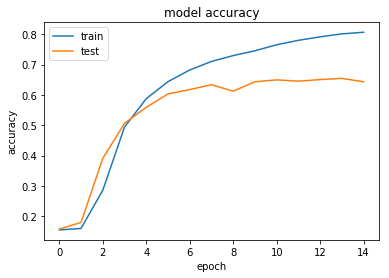

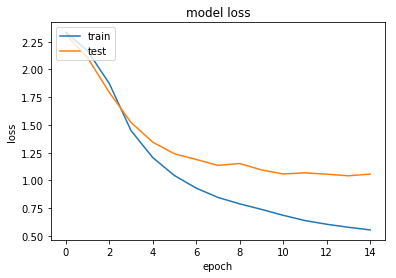

In [25]:
plotHistory(history)

## Predict

In [29]:
loss, acc = model.evaluate(X_train_ngram , y_train, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 89.539569


In [31]:
f = open('pred.txt', 'w')
for item in _labels:
  f.write("%s\n" % item)

    label  count
0       0      7
1       1   5034
2       2    108
3       3   2373
4       4   2132
5       5   2242
6       6   3001
7       7   7150
8       8   2125
9       9      6
10     10   1811
11     11     21


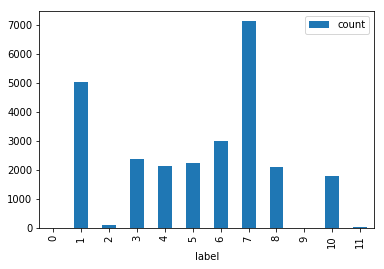

In [55]:
import pandas as pd
df = pd.DataFrame(np.argmax(model.predict(X_train),axis=1), columns=["label"]).groupby(["label"]).size().to_frame(name = 'count').reset_index()
print(df)
df.plot(kind="bar", x = "label")